# LSTIDs Forecasting with the Temporal Fusion Transformer

Author: Konstantinos Themelis


This work is licensed under Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International 


In [18]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import torch
import torch.nn as nn
import torch.optim as optim

from pytorch_lightning.callbacks.early_stopping import EarlyStopping


from sklearn.metrics import precision_score, recall_score, f1_score

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.models import BlockRNNModel,TFTModel
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.likelihood_models import GaussianLikelihood
from darts.utils.missing_values import extract_subseries

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set(rc={'figure.figsize':(14, 9)})

import optuna

import time # cpu time

import warnings
warnings.filterwarnings("ignore")

import logging
logging.disable(logging.CRITICAL)


In [19]:
def date_range(start, end):
    start_date = datetime.strptime(start, '%Y-%m-%d').date()
    end_date = datetime.strptime(end, '%Y-%m-%d').date()
    delta = end_date - start_date 
    days = [start_date + timedelta(days=i) for i in range(delta.days + 1)]
    return list(map(lambda n: n.strftime("%Y-%m-%d"), days))

#### load data

In [20]:
# set parameters
station = 'DB049'
data_path = f'../../datasets'
model_path = f'../../models'
day_start = '2022-01-01'
day_end = '2023-06-30'

dates_list = date_range(day_start, day_end)
split_date = pd.Timestamp("20230501")


#### load SEC time series

In [21]:
# read SEC raw data
df_spcont = pd.read_csv(data_path + f'/{station}/oe_hfi_{station}_nearestfill_20220101_20230630.csv')
df_spcont['date'] = pd.to_datetime(df_spcont['date']) 
display(df_spcont)

ts_sec_Dourbes = TimeSeries.from_dataframe(df_spcont, time_col='date', value_cols='spcont_filtered')
ts_sec_Dourbes = ts_sec_Dourbes.with_columns_renamed('spcont_filtered', 'SEC_Dourbes')


,date,spcont_filtered
0,2022-01-01 00:00:00,-2.0
1,2022-01-01 00:05:00,-2.0
2,2022-01-01 00:10:00,-2.0
3,2022-01-01 00:15:00,-2.0
4,2022-01-01 00:20:00,-2.0
...,...,...
157243,2023-06-30 23:35:00,-2.0
157244,2023-06-30 23:40:00,-2.0
157245,2023-06-30 23:45:00,-2.0
157246,2023-06-30 23:50:00,-2.0


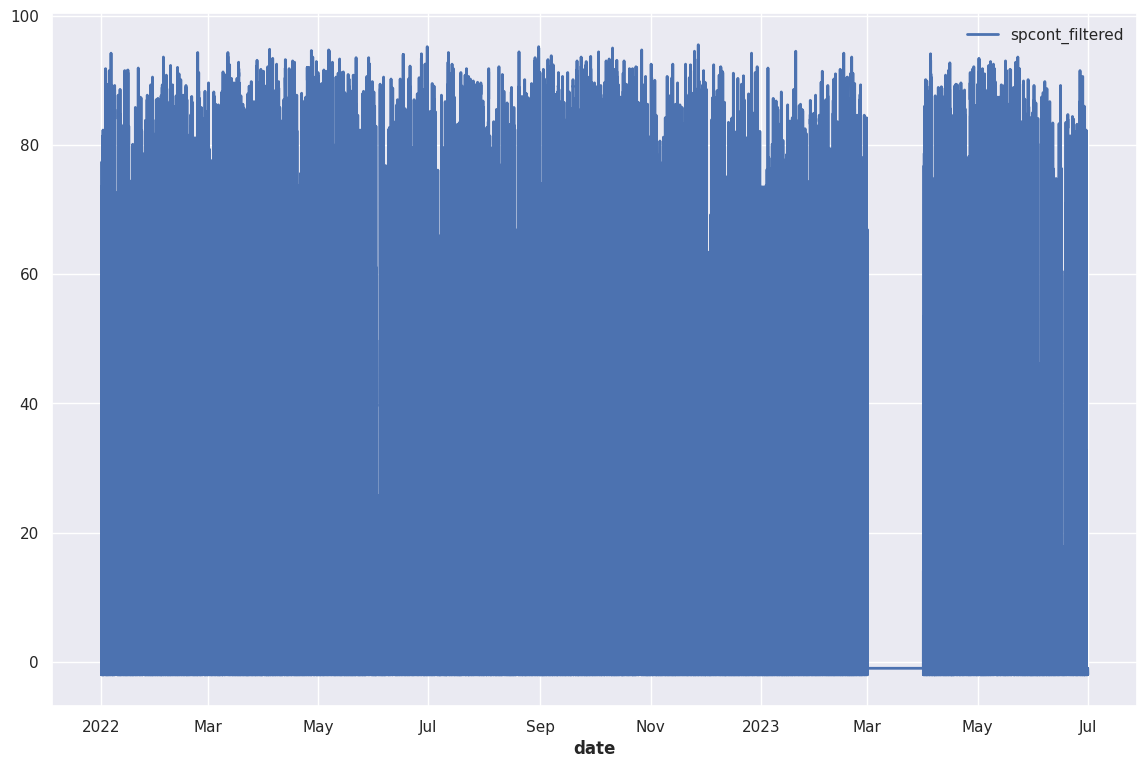

In [22]:
# plot spcont time series 
ts_spcont = TimeSeries.from_dataframe(df_spcont, time_col='date', value_cols='spcont_filtered')
ts_spcont.plot()
plt.show()

#### load image indicators IL, IU and IE

In [23]:
# read fmi data
csv_files = [data_path + f'/fmi/iliuie_{i}.csv' for i in dates_list]
df_fmi = pd.concat(map(pd.read_csv, csv_files))
df_fmi['date'] = pd.to_datetime(df_fmi['date']) 
df_fmi.drop(columns=['year', 'month', 'day', 'hour', 'minutes', 'second', 'la_IL', 'lo_IL', 'la_IU', 'lo_IU'], inplace=True)
display(df_fmi)


,date,IL,IU,IE
0,2022-01-01 00:00:00,-17.8,18.3,36.1
1,2022-01-01 00:05:00,-25.6,15.0,40.6
2,2022-01-01 00:10:00,-28.5,21.9,50.4
3,2022-01-01 00:15:00,-27.5,28.5,56.0
4,2022-01-01 00:20:00,-34.4,28.5,62.9
...,...,...,...,...
283,2023-06-30 23:35:00,-32.4,19.2,51.6
284,2023-06-30 23:40:00,-34.5,17.0,51.5
285,2023-06-30 23:45:00,-35.4,18.4,53.8
286,2023-06-30 23:50:00,-18.8,17.4,36.2


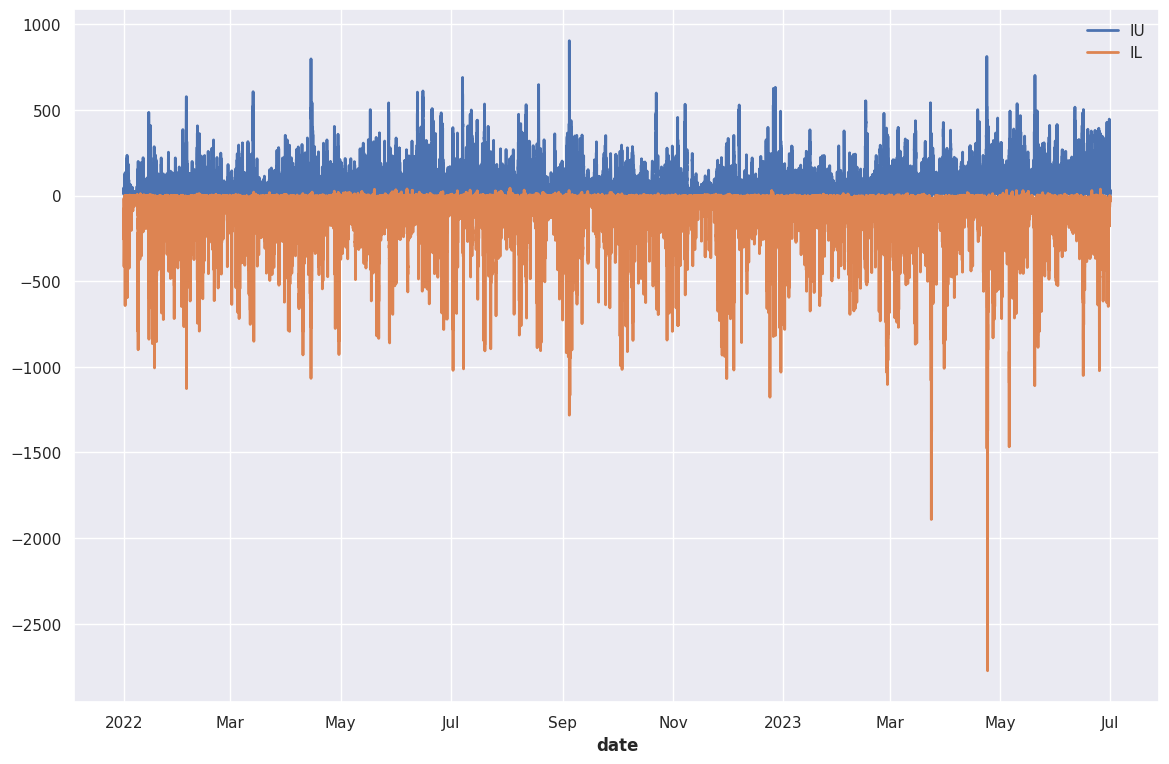

In [24]:
# plot fmi input time series 
ts_IU = TimeSeries.from_dataframe(df_fmi, time_col='date', value_cols='IU')
ts_IL = TimeSeries.from_dataframe(df_fmi, time_col='date', value_cols='IL')
ts_IU.plot()
ts_IL.plot()
plt.show()

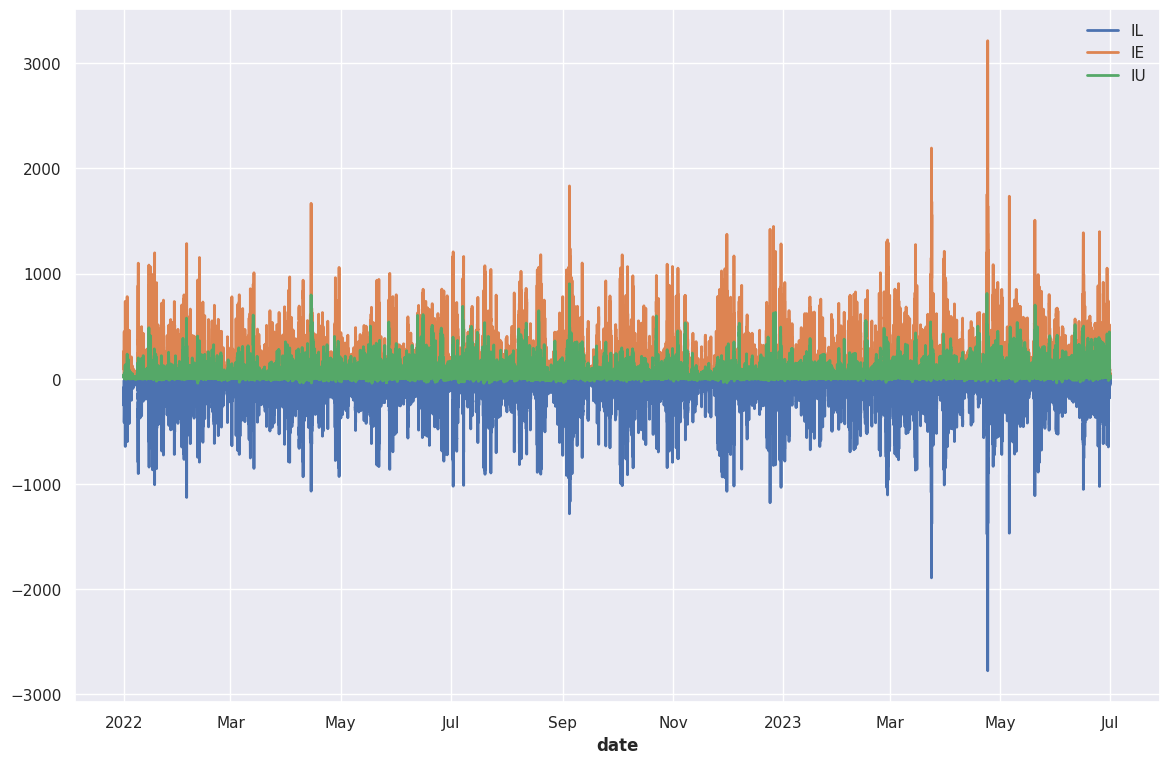

In [25]:
# plot fmi input time series 
ts_fmi = TimeSeries.from_dataframe(df_fmi, time_col='date', value_cols=['IL','IE','IU']) 
ts_fmi.plot()
plt.show()

#### load gnss tec gradient time series

In [26]:
# read gnss data
csv_files = [data_path + f'/gnss/gnss_{i}.csv' for i in dates_list]

# read csv files from list
df_gnss = pd.concat(map(pd.read_csv, csv_files))

# shift by 30sec to align with other measurements
df_gnss['date'] = pd.to_datetime(df_gnss['date']) - timedelta(seconds=30)
df_gnss.drop(columns=['id', 'pubid', 'product', 'activity', 'day'], inplace=True)
if df_gnss.shape[0] < df_spcont.shape[0]:
    df_tmp = pd.date_range(start=datetime.strptime(day_start, "%Y-%m-%d"), 
                     end=datetime.strptime(day_end, "%Y-%m-%d") + timedelta(hours=23) + timedelta(minutes=55), freq='5T')\
        .to_frame(index=False, name='date')
    df_gnss = pd.merge(df_tmp, df_gnss, on='date', how='left')
    #df_gnss['cvalue'] = df_gnss['cvalue'].interpolate(method='polynomial', order=2)
# df_gnss.fillna(0, inplace=True)
# df_gnss['cvalue'].clip(lower=0, inplace=True)
display(df_gnss)

# print((df_gnss['cvalue'] < 0).sum().sum(), df_gnss['cvalue'].isnull().sum())

,date,cvalue
0,2022-01-01 00:00:00,0.460
1,2022-01-01 00:05:00,0.429
2,2022-01-01 00:10:00,0.414
3,2022-01-01 00:15:00,0.400
4,2022-01-01 00:20:00,0.409
...,...,...
157243,2023-06-30 23:35:00,0.686
157244,2023-06-30 23:40:00,0.676
157245,2023-06-30 23:45:00,0.733
157246,2023-06-30 23:50:00,0.734


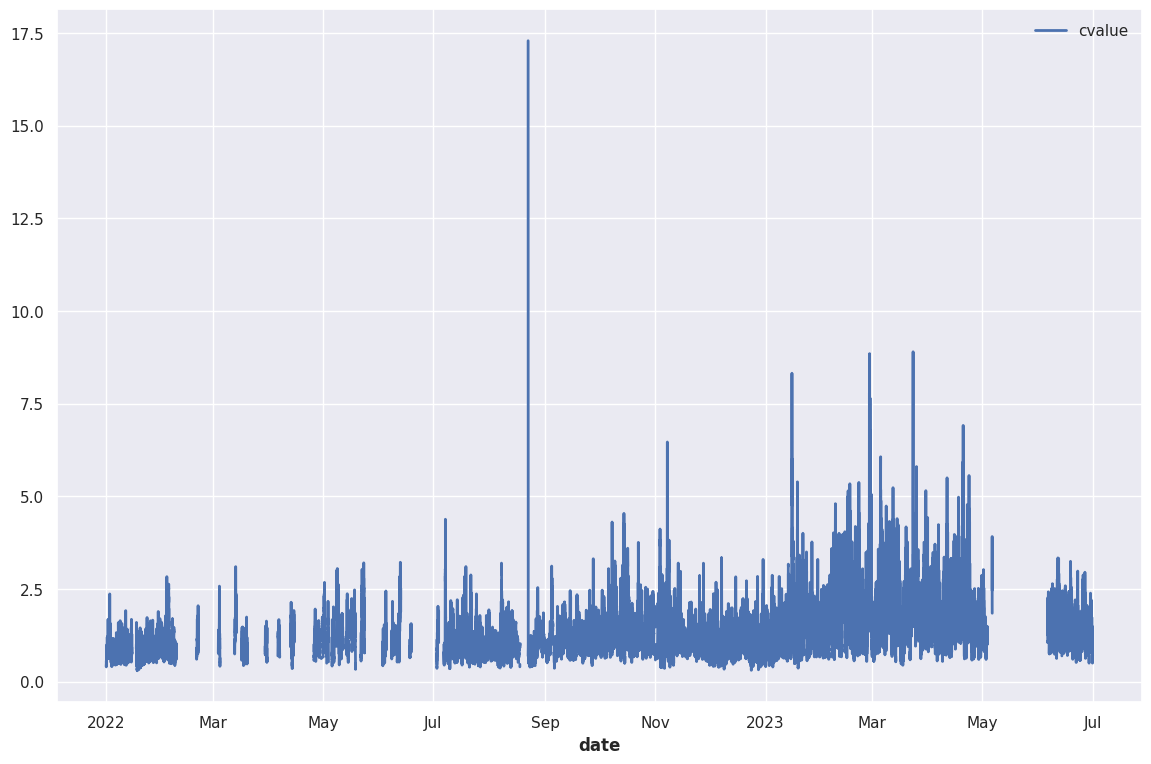

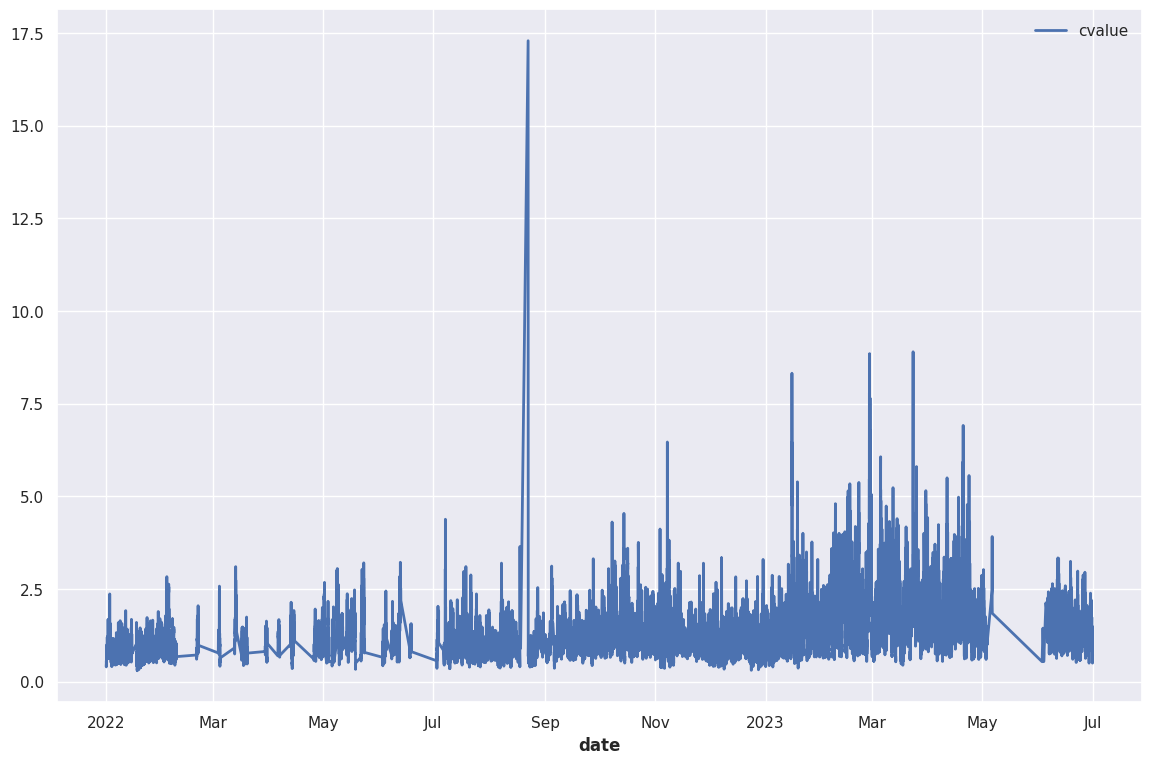

In [27]:
# plot input gnss time series 
ts_gnss = TimeSeries.from_dataframe(df_gnss, time_col='date', value_cols='cvalue')
ts_gnss.plot()
plt.show()

transformer = MissingValuesFiller()
ts_gnss_filled = transformer.transform(ts_gnss)
ts_gnss_filled.plot()
plt.show()

#### create time series from input data

In [28]:
# merge input dataframes
df_all = df_spcont.merge(df_fmi, on='date', validate = 'one_to_one').merge(df_gnss, on='date', validate = 'one_to_one')
df_all['spcont_filtered'] = df_all['spcont_filtered'].apply(lambda x: x if x >=0 else np.nan)
df_all['hour'] = df_all['date'].dt.hour
df_all['month'] = df_all['date'].dt.month
df_all['mask'] = df_all['spcont_filtered'].apply(lambda x: True if x >=0 else False)
display(df_all)
df_all.info()

,date,spcont_filtered,IL,IU,IE,cvalue,hour,month,mask
0,2022-01-01 00:00:00,NaN,-17.8,18.3,36.1,0.460,0,1,False
1,2022-01-01 00:05:00,NaN,-25.6,15.0,40.6,0.429,0,1,False
2,2022-01-01 00:10:00,NaN,-28.5,21.9,50.4,0.414,0,1,False
3,2022-01-01 00:15:00,NaN,-27.5,28.5,56.0,0.400,0,1,False
4,2022-01-01 00:20:00,NaN,-34.4,28.5,62.9,0.409,0,1,False
...,...,...,...,...,...,...,...,...,...
157243,2023-06-30 23:35:00,NaN,-32.4,19.2,51.6,0.686,23,6,False
157244,2023-06-30 23:40:00,NaN,-34.5,17.0,51.5,0.676,23,6,False
157245,2023-06-30 23:45:00,NaN,-35.4,18.4,53.8,0.733,23,6,False
157246,2023-06-30 23:50:00,NaN,-18.8,17.4,36.2,0.734,23,6,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157248 entries, 0 to 157247
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             157248 non-null  datetime64[ns]
 1   spcont_filtered  31059 non-null   float64       
 2   IL               157248 non-null  float64       
 3   IU               157248 non-null  float64       
 4   IE               157248 non-null  float64       
 5   cvalue           106736 non-null  float64       
 6   hour             157248 non-null  int32         
 7   month            157248 non-null  int32         
 8   mask             157248 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(5), int32(2)
memory usage: 8.5 MB


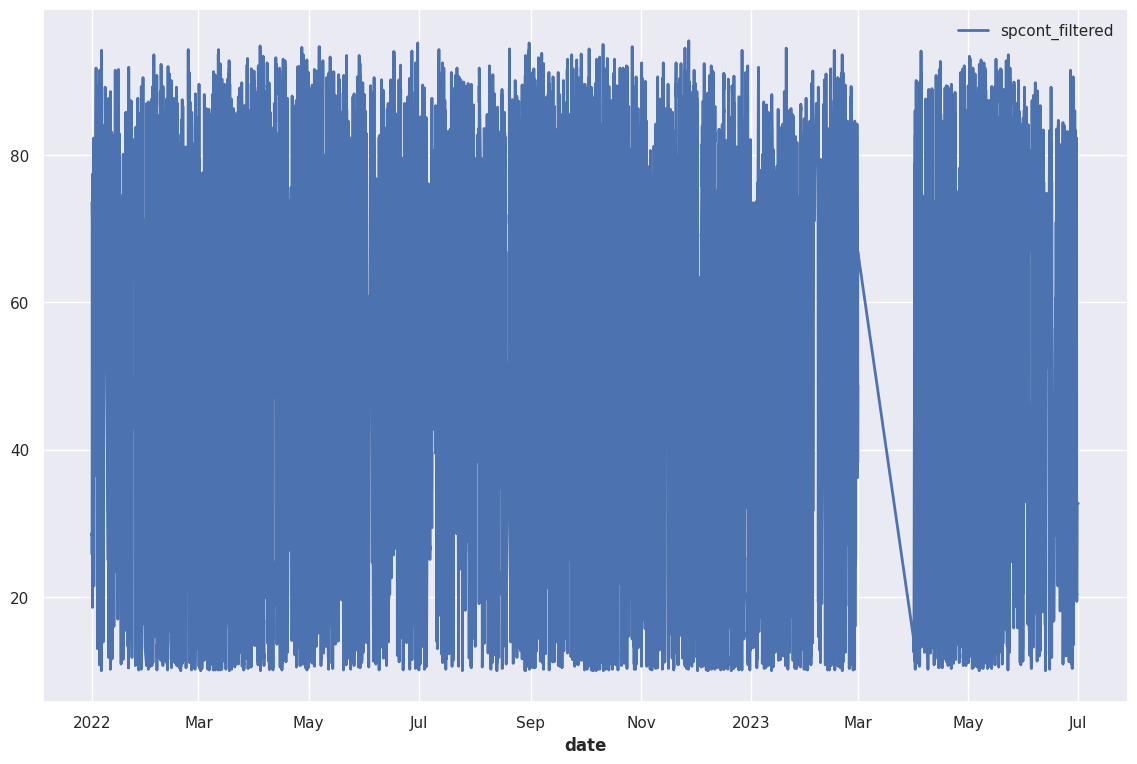

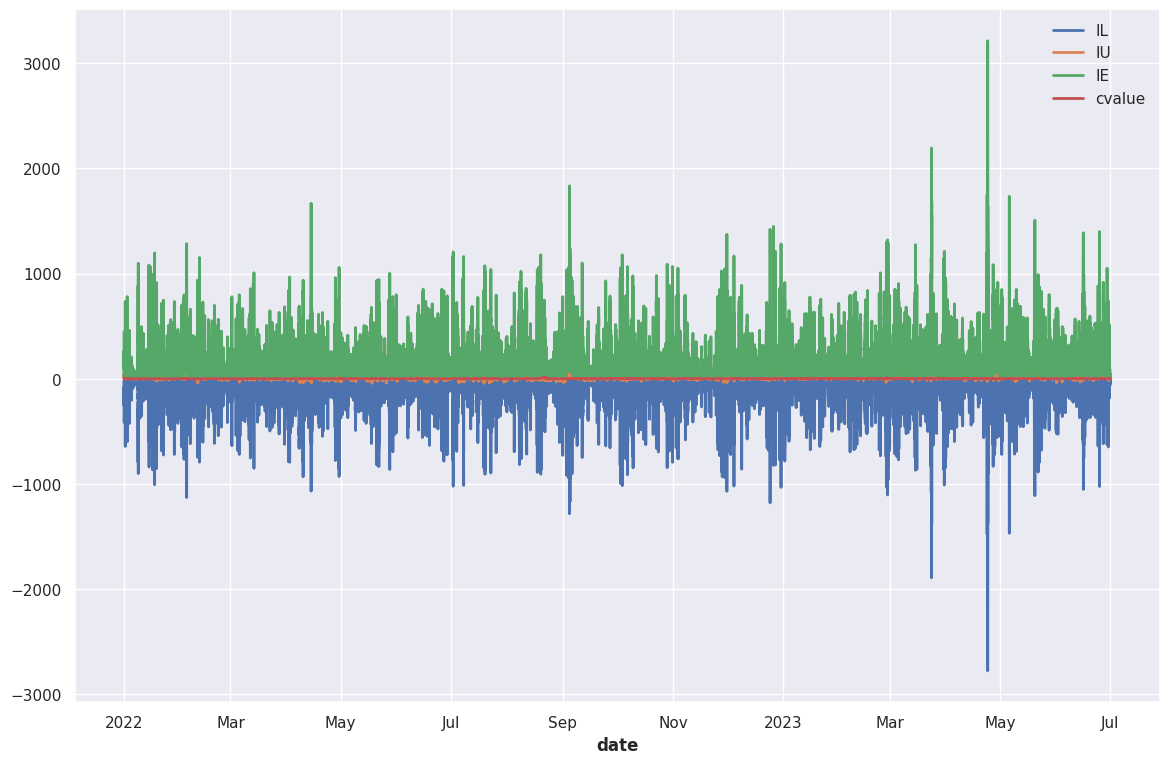

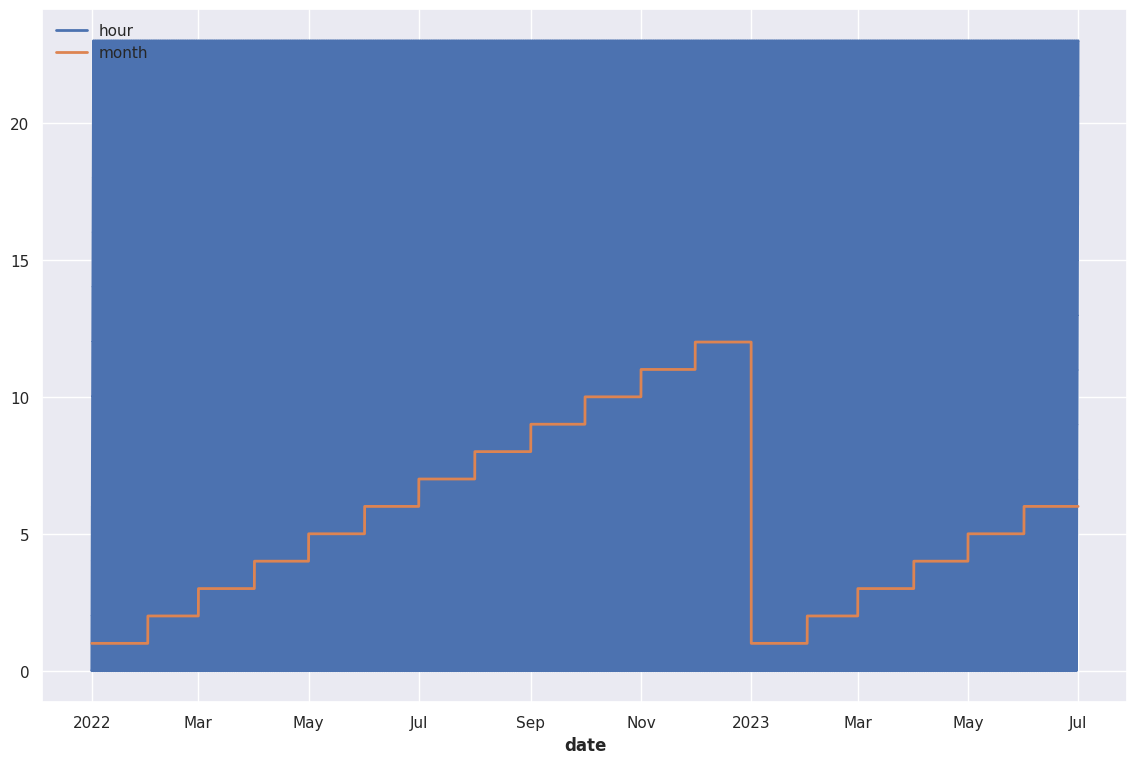

In [29]:
# create and fill target time series
ts_spcont = TimeSeries.from_dataframe(df_all, 
                                      time_col='date',
                                      value_cols=['spcont_filtered']
                                     ) 

transformer_spcont = MissingValuesFiller()
ts_spcont_filled = transformer_spcont.transform(ts_spcont)
ts_spcont_filled.plot()
plt.show()

# create and fill past covariates
ts_pastcovs = TimeSeries.from_dataframe(df_all,
                                        time_col='date',
                                        value_cols=['IL', 'IU', 'IE', 'cvalue'] 
                                       ) 
transformer_past = MissingValuesFiller()
ts_pastcovs_filled = transformer_past.transform(ts_pastcovs)
ts_pastcovs_filled.plot()
plt.show()

# create and fill future covariates
ts_futcovs = TimeSeries.from_dataframe(df_all,
                                       time_col='date',
                                       value_cols=['hour', 'month']
                                      ) 
ts_futcovs.plot()
plt.show()

#### time series preprocessing 

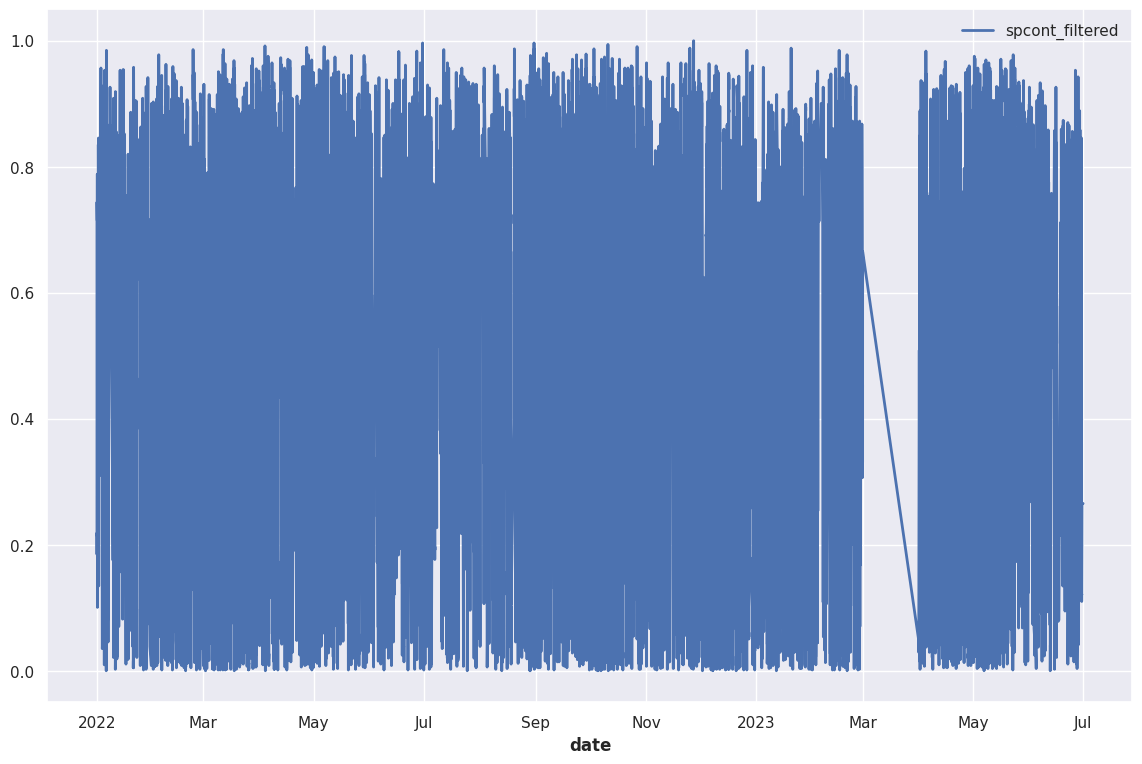

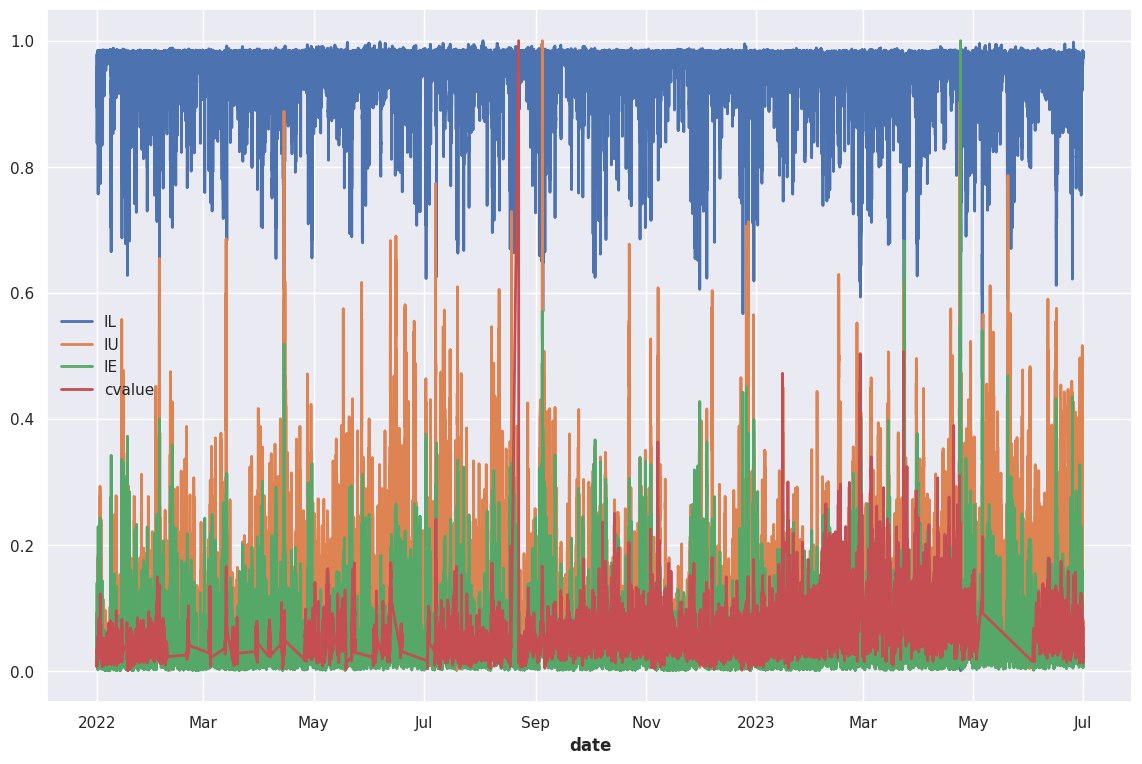

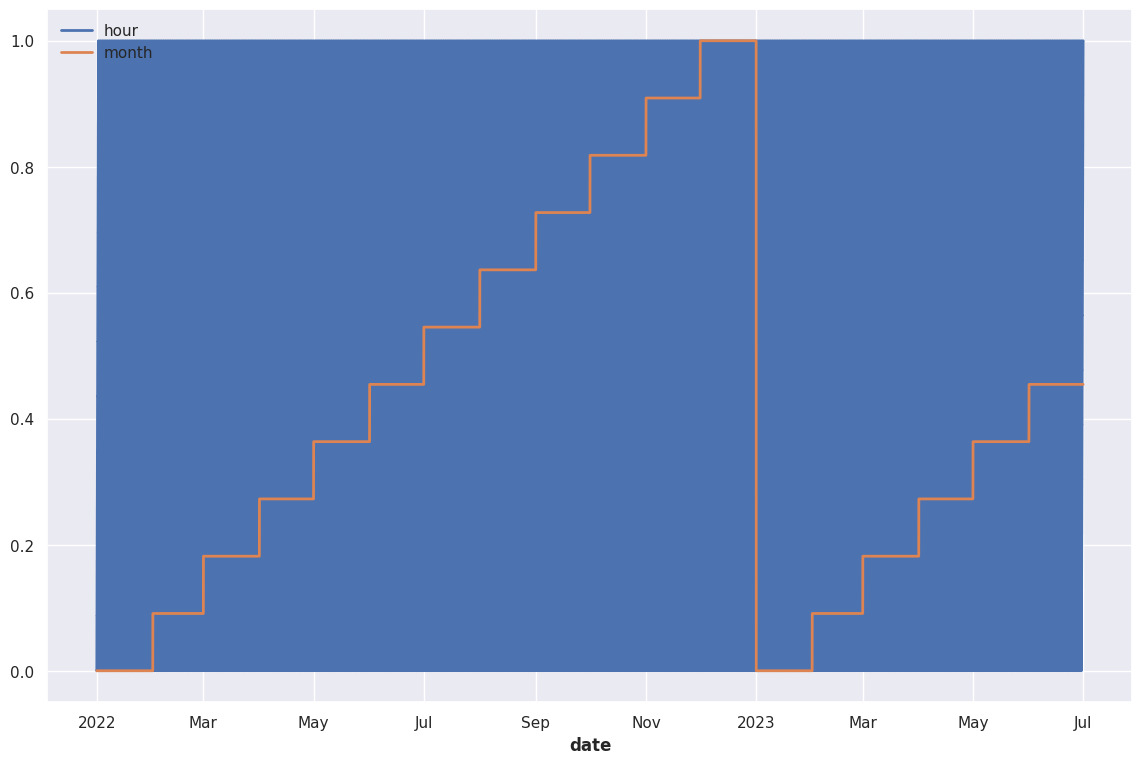

In [30]:
scaler_spcont, scaler_pastcovs, scaler_futcovs = Scaler(), Scaler(), Scaler()
ts_spcont_scaled = scaler_spcont.fit_transform(ts_spcont_filled)
ts_spcont_scaled.plot()
plt.show()

ts_pastcovs_scaled = scaler_pastcovs.fit_transform(ts_pastcovs_filled)
ts_pastcovs_scaled.plot()
plt.show()

ts_futcovs_scaled = scaler_futcovs.fit_transform(ts_futcovs)
ts_futcovs_scaled.plot()
plt.show()

#### train / validation split

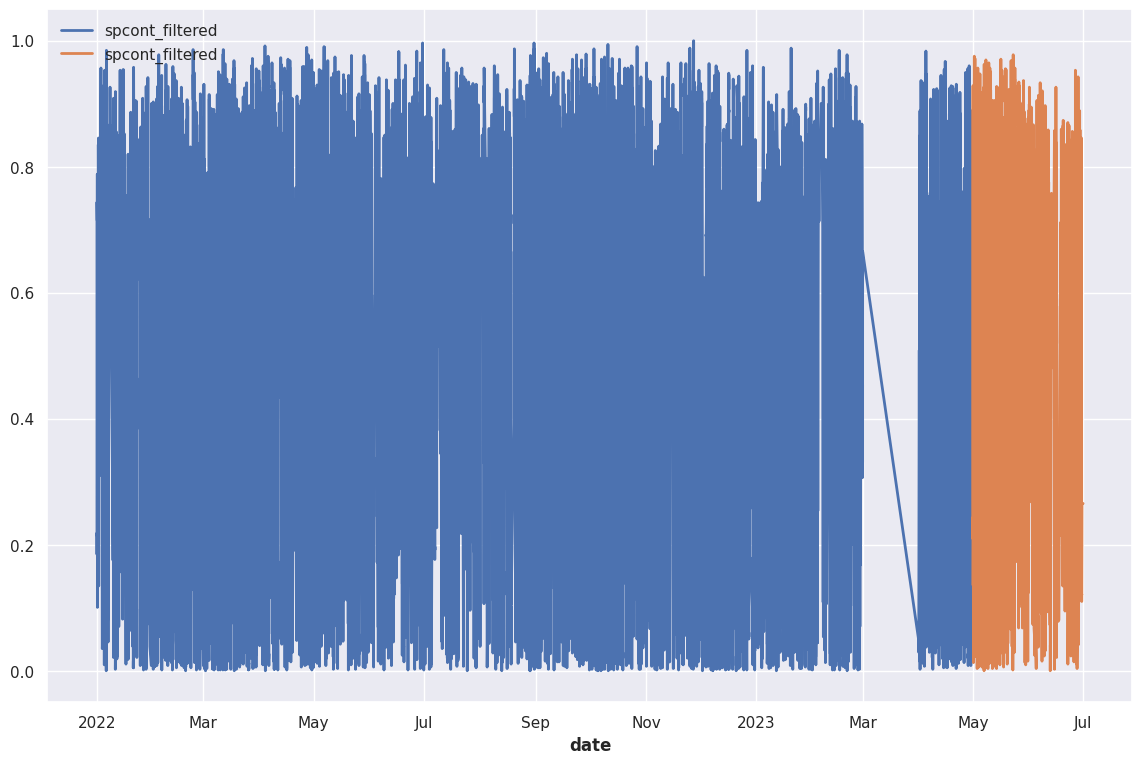

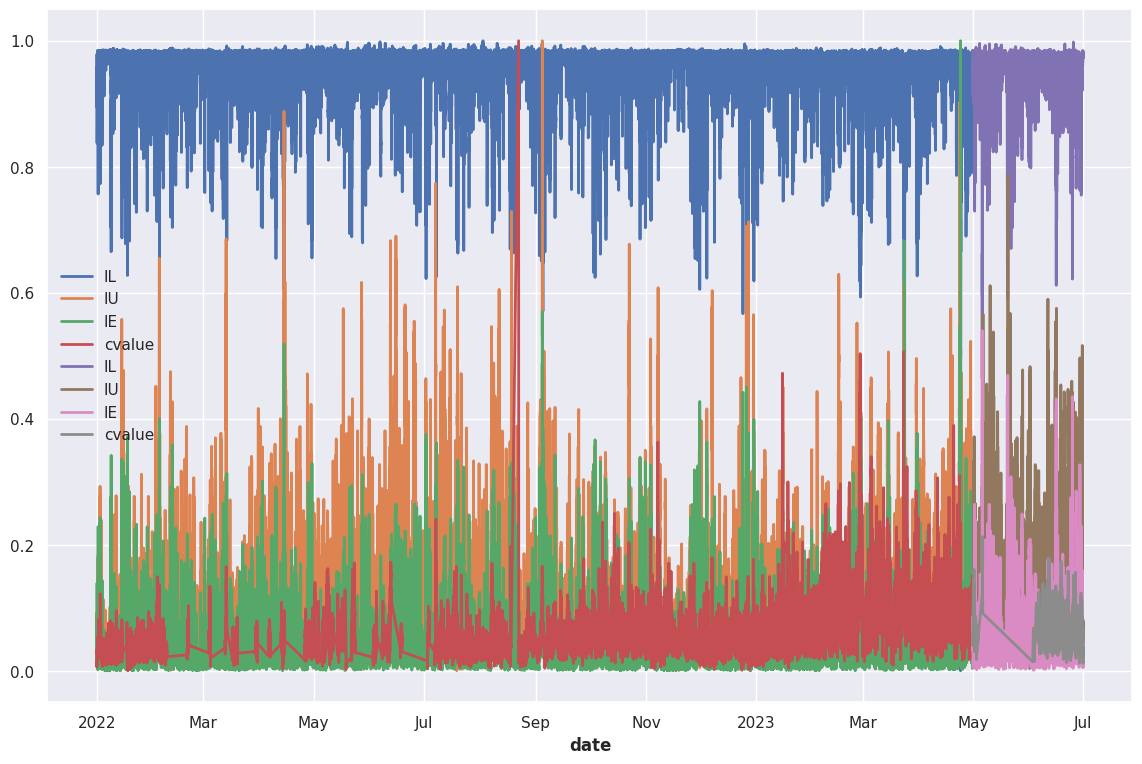

In [31]:
# split
train_spcont, val_spcont = ts_spcont_scaled.split_after(split_date)
train_spcont.plot()
val_spcont.plot()
plt.show()

train_pastcovs, val_pastcovs = ts_pastcovs_scaled.split_after(split_date)
train_pastcovs.plot()
val_pastcovs.plot()
plt.show()

# train_futcovs, val_futcovs = ts_futcovs_scaled.split_after(split_date)
# train_futcovs.plot()
# val_futcovs.plot()
# plt.show()

# get valid samples indexes in validation set
ts_mask = TimeSeries.from_dataframe(df_all, time_col='date', value_cols='mask')
train_mask, val_mask = ts_mask.split_after(split_date)


#### load / save trained model

In [32]:
tft_model = TFTModel.load(model_path + f'/{station}/TFTModel_hd76_ch70_drop0.019526791942847878_ep256_ll1_batch1024.pt') 

#### evaluate performance


In [33]:
# perform prediction for marked days in validation set
mark1 = pd.Timestamp('2023-06-15')
mark2 = pd.Timestamp('2023-06-17')

tft_model_predict = tft_model.historical_forecasts(series=val_spcont.slice(mark1-pd.Timedelta(minutes=350), mark2),
                                                   past_covariates=val_pastcovs,
                                                   future_covariates=ts_futcovs_scaled,
                                                   start=None, 
                                                   num_samples=10,
                                                   forecast_horizon=1,
                                                   stride=1,
                                                   retrain=False,
                                                   verbose=False
                                                  )

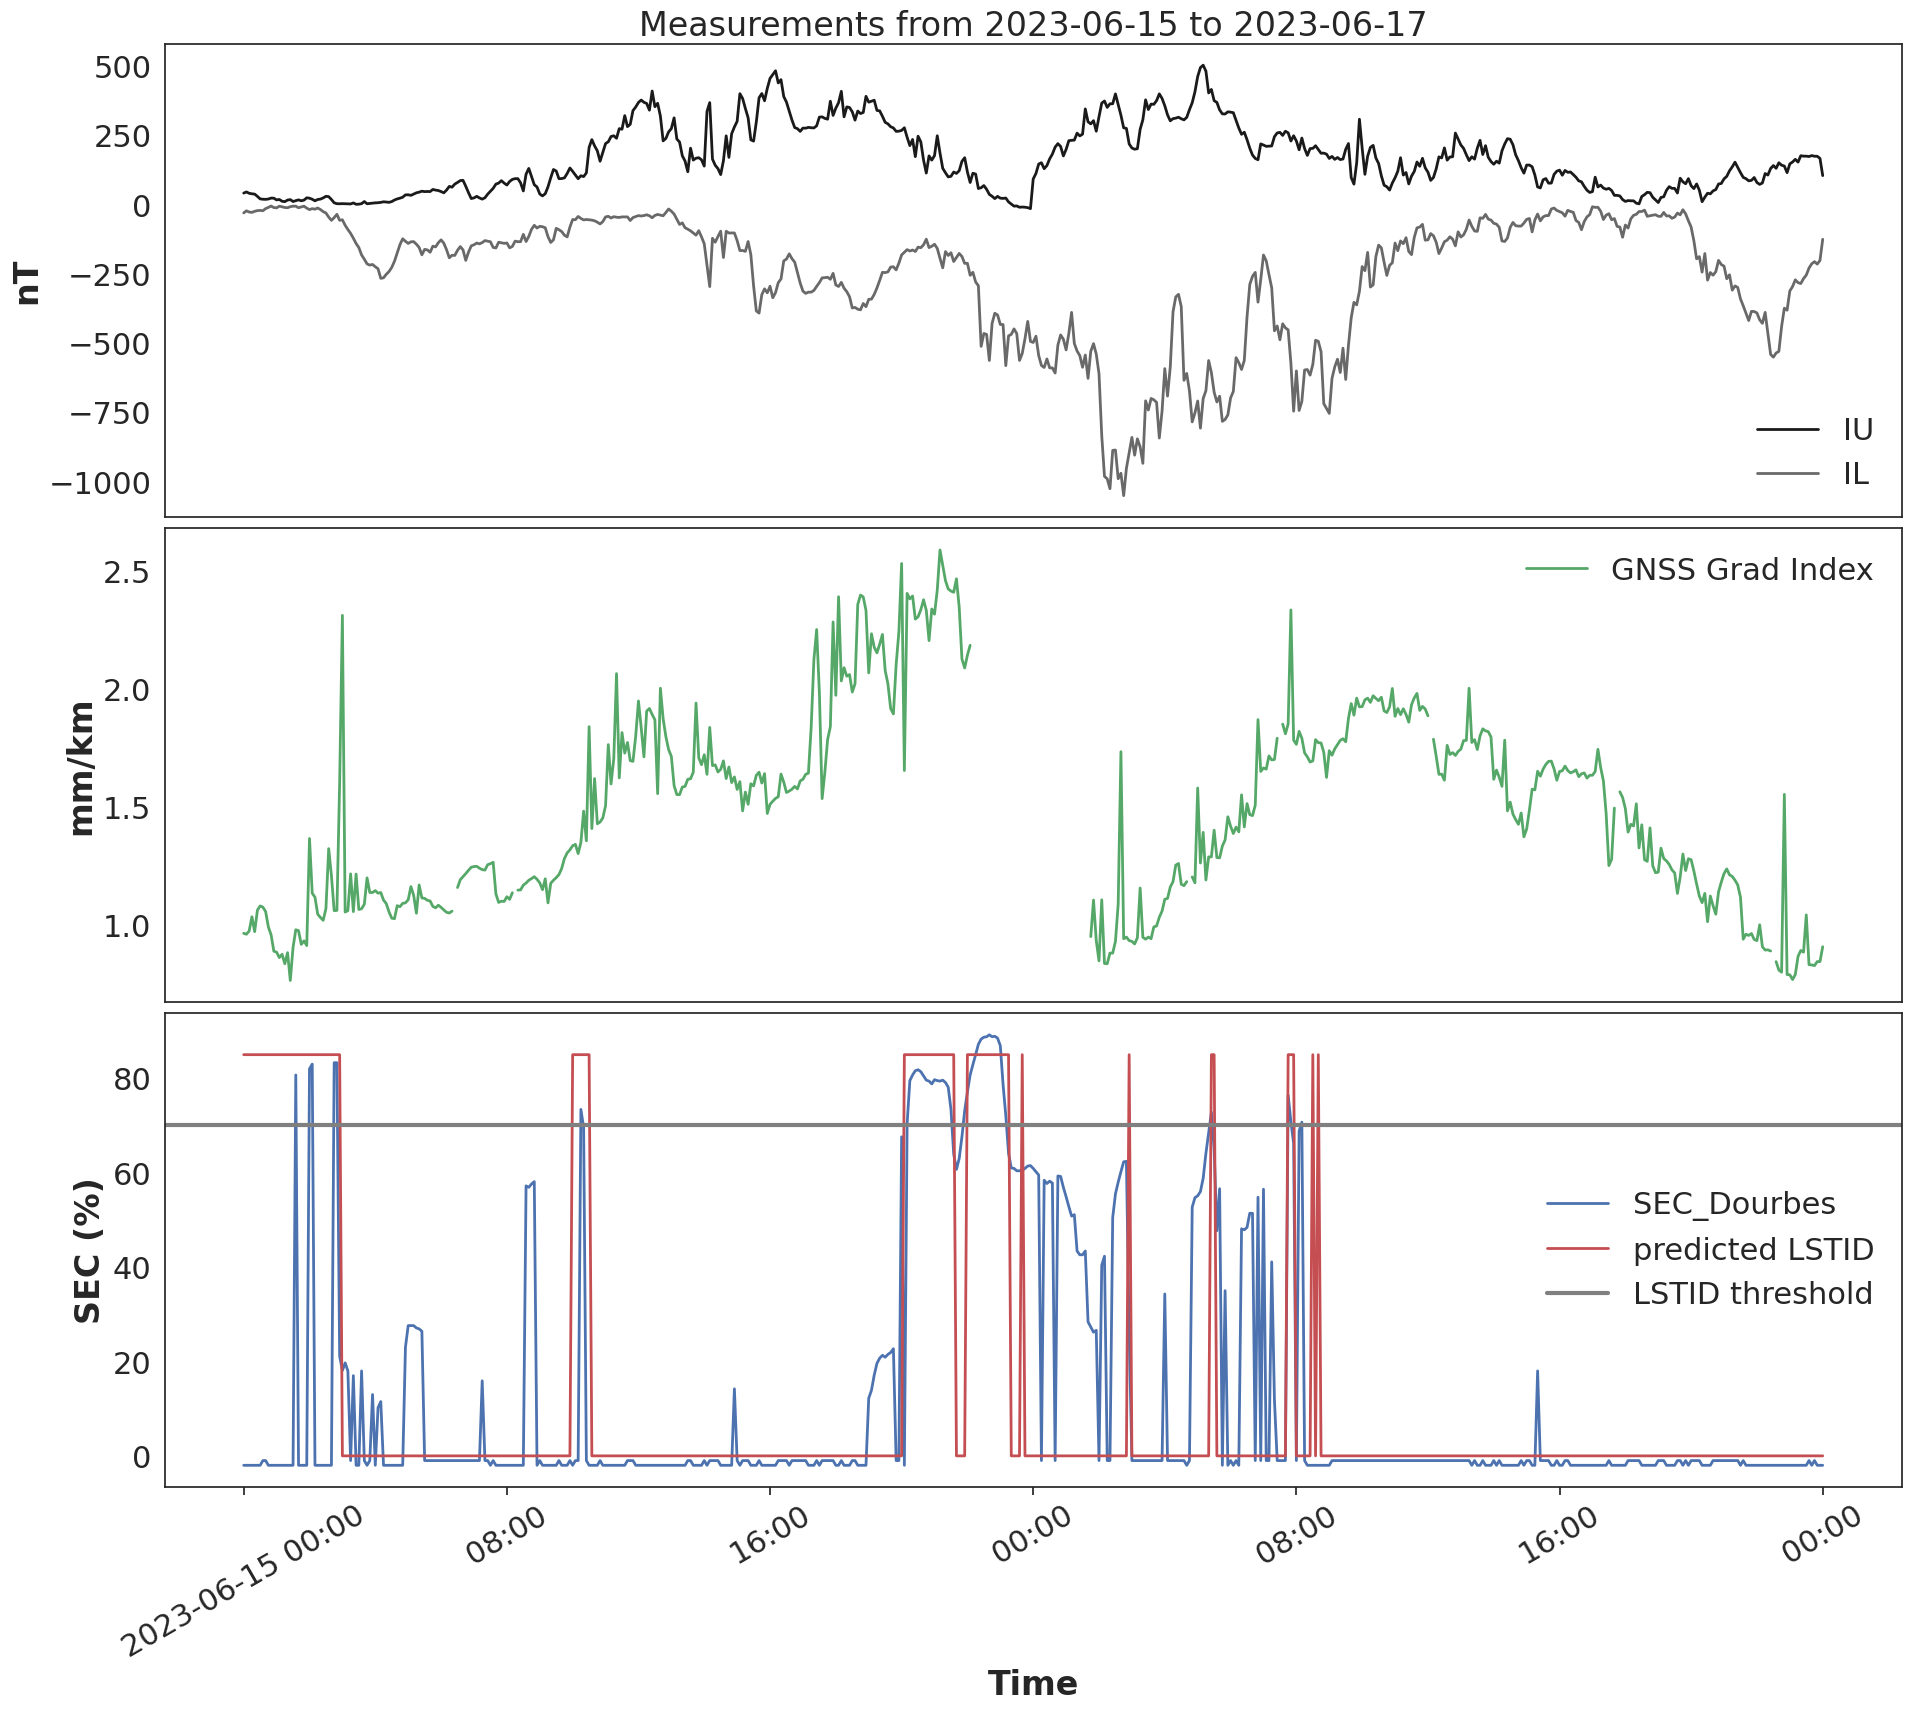

In [34]:

def my_format_function(x, pos=None):
    x = mdates.num2date(x)
    if (pos %8 ==0):
        fmt = '%Y-%m-%d %H:%M'
    else:
        fmt = '%H:%M'
    label = x.strftime(fmt)
    return label
  
theta = .7
y_true = np.digitize(val_spcont.slice(mark1, mark2).values(), np.array([theta]), right=False)
y_pred = np.digitize(tft_model_predict.slice(mark1, mark2).mean().values(), np.array([theta]), right=False)
ts_true = TimeSeries.from_times_and_values(val_spcont.slice(mark1, mark2).time_index, 85*y_true)
ts_pred = TimeSeries.from_times_and_values(val_spcont.slice(mark1, mark2).time_index, 85*y_pred)
ts_pred_Dourbes = ts_pred.with_columns_renamed('0', 'predicted LSTID')


day1 = mark1.strftime('%Y-%m-%d')
day2 = mark2.strftime('%Y-%m-%d')
sns.set_theme(style='white', font_scale=2)
fig, axes = plt.subplots(3,1, sharex=True, layout="constrained", figsize=(19,17))
ts_IU.slice(mark1, mark2).plot(ax=axes[0], c='k')
ts_IL.slice(mark1, mark2).plot(ax=axes[0], c='dimgrey')
ts_gnss.slice(mark1, mark2).with_columns_renamed('cvalue', 'GNSS Grad Index').plot(ax=axes[1], c='g')
axes[1].set(ylabel='mm/km')
ts_sec_Dourbes.slice(mark1, mark2).plot(ax=axes[2])
ts_pred_Dourbes.plot(ax=axes[2],c='r')
axes[2].axhline(y=100*theta, linewidth=3, color='grey', label='LSTID threshold')
axes[2].legend(loc='center right')
axes[2].set(ylabel='SEC (%)')
axes[0].set_title(f'Measurements from {day1} to {day2}')
axes[0].set(xlabel=None)
axes[0].set(ylabel='nT')
axes[0].legend(loc='lower right')
axes[1].set(xlabel=None)
axes[2].set(xlabel='Time')
#axes[2].xaxis.set_major_formatter(myFmt)
locator = mdates.AutoDateLocator(minticks=20)
locator.intervald[4] = [8] 
formatter = mdates.AutoDateFormatter(locator)
formatter.scaled[1/(24)] = my_format_function
axes[2].xaxis.set_ticks_position('bottom')
axes[2].xaxis.set_major_locator(locator)
axes[2].xaxis.set_major_formatter(formatter)
plt.xticks(rotation=30)
plt.show()

____